What if we just used the forward model to get exchange between substrate pools and calculate the probabilities based on the proportions of substrate? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and attribute any extra to a different, missing process?

If the hybrid process is drawing equally on the NH4+ and NO2- pools, should we calculate the total rate not as the sum of rate constants times substrates, but rather as a minimum of whichever substrate is the limiting reagent?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for initialization
from collections import namedtuple

# use for plotting interpolations of measured incubation data
import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Set up the model:

In [2]:
### READ IN TRAINING DATA ###
PS2SCM15NO2 = sc.grid_data(filename=f'{sc.datapath()}00_incubationdata.csv',
                          station="PS2", feature="SCM", tracer="NO2-", 
                          T=1000)

In [3]:
### SUBSTRATE INITS ###
bgc = sc.BioGeoChemistry("PS2SCM")

In [4]:
### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

In [31]:
### STATE VARIABLE ARRAYS & MODEL PARAMS ###
(dt, T, times,
 n2o_44, n2o_45a, n2o_45b, n2o_46,
 nh4_14, nh4_15, no2_14, no2_15, no3_14, no3_15,
 n2_28, n2_29, n2_30,
 afnh4, afno2, afno3) = sc.modelparams(bgc, PS2SCM15NO2)

In [32]:
### INITIAL GUESS FOR OPTIMIZATION ###
x = sc.kestimates(bgc,
                  inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv'),
                  station="PS2", feature="SCM", hybridtracer="NO2-") 

In [33]:
x

[0.0, 2.8050367317752543e-09, 2.6337722293500452e-09, 1.1498146189583089e-07]

In [34]:
def objective(x):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(nh4_14[iT]+nh4_15[iT])*(no2_14[iT]+no2_15[iT])

        Jnitrification = knitrification*((nh4_14[iT]+nh4_15[iT])**2)
        Jdenitno2 = kdenitno2*((no2_14[iT]+no2_15[iT])**2)
        Jdenitno3 = kdenitno3*((no3_14[iT]+no3_15[iT])**2)

        # update substrate values
        nh4_14[iT+1,:] = nh4_14[iT,:] + dt*(
            -bgc.kNH4TONO2*nh4_14[iT]

            -Jnitrification*(1-afnh4[iT,:])
            -Jhybrid*(1-afnh4[iT,:]))

        nh4_15[iT+1,:] = nh4_15[iT,:] + dt*(
            -bgc.kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]

            -Jnitrification*afnh4[iT,:]
            -Jhybrid*afnh4[iT,:])

        afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])

        no2_14[iT+1,:] = no2_14[iT,:] + dt*(
            bgc.kNH4TONO2*nh4_14[iT]
            +bgc.kNO3TONO2*no3_14[iT]
            -bgc.kNO2TONO3*no2_14[iT]

            -Jdenitno2*(1-afno2[iT,:])
            -Jhybrid*(1-afno2[iT,:]))

        no2_15[iT+1,:] = no2_15[iT,:] + dt*(
            bgc.kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]

            -Jdenitno2*(afno2[iT,:])
            -Jhybrid*afno2[iT,:])

        no3_14[iT+1,:] = no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*no2_14[iT]
            -bgc.kNO3TONO2*no3_14[iT]

            -Jdenitno3*(1-afno3[iT,:]))

        no3_15[iT+1,:] = no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]

            -Jdenitno3*afno3[iT,:])

        # recalculate atom fractions at each time step
        afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])
        afno2[iT+1,:] = no2_15[iT+1,:]/(no2_14[iT+1,:] + no2_15[iT+1,:])
        afno3[iT+1,:] = no3_15[iT+1,:]/(no3_14[iT+1,:] + no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no2 = Jdenitno2/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid = Jhybrid/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(afno2[iT], afnh4[iT])

        p46hybrid = p1
        p45ahybrid = p2 # (p2+p3)/2
        p45bhybrid = p3 # (p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(afnh4[iT], afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(afno2[iT], afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(afno3[iT], afno3[iT])

        # update N2O values
        n2o_46[iT+1,:] = n2o_46[iT,:] + dt*(
            +total_hybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

        n2o_45a[iT+1, :] = n2o_45a[iT,:] + dt*(
            +total_hybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT])

        n2o_45b[iT+1, :] = n2o_45b[iT,:] + dt*(
            +total_hybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

        n2o_44[iT+1,:] = n2o_44[iT,:] + dt*(
            +total_hybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*n2o_44[iT])

        # update N2 values

        n2_28[iT+1,:] = n2_28[iT,:] + dt*(bgc.kN2OCONS*n2o_44[iT])

        n2_29[iT+1,:] = n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

        n2_30[iT+1,:] = n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

    #calculate cost
    cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                    modeled_44 = n2o_44,
                    modeled_45a = n2o_45a,
                    modeled_45b = n2o_45b,
                    modeled_46 = n2o_46,
                    weights = np.array([1,10,10,10]))
    return cost

In [35]:
objective(x)

0.8601312717463656

## Optimization

In [36]:
xguess = x

xguess

[0.0, 2.8050367317752543e-09, 2.6337722293500452e-09, 1.1498146189583089e-07]

In [37]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min = np.array(xguess)*0.75
r_max = np.array(xguess)*1.25
# define the starting point as a random sample from the domain
pt = r_min + rand(4)*(r_max - r_min)

pt

array([0.00000000e+00, 2.35833928e-09, 2.16330602e-09, 1.31749321e-07])

In [38]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, pt, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 137
Solution: f([0.00000000e+00 6.16147244e-09 3.66362134e-09 8.61272025e-08]) = 0.37454


In [39]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selcted x0
result = minimize(objective, xguess, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 137
Solution: f([0.00000000e+00 6.14070082e-09 3.66638618e-09 8.63100600e-08]) = 0.37452


In [40]:
objective(result.x)

0.37451743049310815

In [41]:
result.x

array([0.00000000e+00, 6.14070082e-09, 3.66638618e-09, 8.63100600e-08])

In [42]:
### STATE VARIABLE ARRAYS & MODEL PARAMS ###
(dt, T, times,
 n2o_44, n2o_45a, n2o_45b, n2o_46,
 nh4_14, nh4_15, no2_14, no2_15, no3_14, no3_15,
 n2_28, n2_29, n2_30,
 afnh4, afno2, afno3) = sc.modelparams(bgc, PS2SCM15NO2)


x = result.x

### UNPACK X ###
[knitrification, kdenitno2, kdenitno3, khybrid] = x

### TIME STEPPING ###
for iT in range(T-1):

    Jhybrid = khybrid*(nh4_14[iT]+nh4_15[iT])*(no2_14[iT]+no2_15[iT])

    Jnitrification = knitrification*((nh4_14[iT]+nh4_15[iT])**2)
    Jdenitno2 = kdenitno2*((no2_14[iT]+no2_15[iT])**2)
    Jdenitno3 = kdenitno3*((no3_14[iT]+no3_15[iT])**2)

    # update substrate values
    nh4_14[iT+1,:] = nh4_14[iT,:] + dt*(
        -bgc.kNH4TONO2*nh4_14[iT]

        -Jnitrification*(1-afnh4[iT,:])
        -Jhybrid*(1-afnh4[iT,:]))

    nh4_15[iT+1,:] = nh4_15[iT,:] + dt*(
        -bgc.kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]

        -Jnitrification*afnh4[iT,:]
        -Jhybrid*afnh4[iT,:])

    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])

    no2_14[iT+1,:] = no2_14[iT,:] + dt*(
        bgc.kNH4TONO2*nh4_14[iT]
        +bgc.kNO3TONO2*no3_14[iT]
        -bgc.kNO2TONO3*no2_14[iT]

        -Jdenitno2*(1-afno2[iT,:])
        -Jhybrid*(1-afno2[iT,:]))

    no2_15[iT+1,:] = no2_15[iT,:] + dt*(
        bgc.kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]
        +bgc.kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]
        -bgc.kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]

        -Jdenitno2*(afno2[iT,:])
        -Jhybrid*afno2[iT,:])

    no3_14[iT+1,:] = no3_14[iT,:] + dt*(
        bgc.kNO2TONO3*no2_14[iT]
        -bgc.kNO3TONO2*no3_14[iT]

        -Jdenitno3*(1-afno3[iT,:]))

    no3_15[iT+1,:] = no3_15[iT,:] + dt*(
        bgc.kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]
        -bgc.kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]

        -Jdenitno3*afno3[iT,:])

    # recalculate atom fractions at each time step
    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])
    afno2[iT+1,:] = no2_15[iT+1,:]/(no2_14[iT+1,:] + no2_15[iT+1,:])
    afno3[iT+1,:] = no3_15[iT+1,:]/(no3_14[iT+1,:] + no3_15[iT+1,:])

    # calculate total rates of N2O production from substrates

    total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
    total_denit_no2 = Jdenitno2/2
    total_denit_no3 = Jdenitno3/2
    total_hybrid = Jhybrid/2

    # calculate probabilities of isotopomer formation

    p1, p2, p3, p4 = sc.binomial(afno2[iT], afnh4[iT])

    p46hybrid = p1
    p45ahybrid = p2 # (p2+p3)/2
    p45bhybrid = p3 # (p2+p3)/2
    p44hybrid = p4

    p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(afnh4[iT], afnh4[iT])
    p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(afno2[iT], afno2[iT])
    p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(afno3[iT], afno3[iT])

    # update N2O values
    n2o_46[iT+1,:] = n2o_46[iT,:] + dt*(
        +total_hybrid*p46hybrid
        +total_nitrification*p46nh4
        +total_denit_no2*p46no2
        +total_denit_no3*p46no3
        -bgc.kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

    n2o_45a[iT+1, :] = n2o_45a[iT,:] + dt*(
        +total_hybrid*p45ahybrid
        +total_nitrification*p45anh4
        +total_denit_no2*p45ano2
        +total_denit_no3*p45ano3
        -bgc.kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT])

    n2o_45b[iT+1, :] = n2o_45b[iT,:] + dt*(
        +total_hybrid*p45bhybrid
        +total_nitrification*p45bnh4
        +total_denit_no2*p45bno2
        +total_denit_no3*p45bno3
        -bgc.kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

    n2o_44[iT+1,:] = n2o_44[iT,:] + dt*(
        +total_hybrid*p44hybrid
        +total_nitrification*p44nh4
        +total_denit_no2*p44no2
        +total_denit_no3*p44no3
        -bgc.kN2OCONS*n2o_44[iT])

    # update N2 values

    n2_28[iT+1,:] = n2_28[iT,:] + dt*(bgc.kN2OCONS*n2o_44[iT])

    n2_29[iT+1,:] = n2_29[iT,:] + dt*(
        bgc.kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT]
        +bgc.kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

    n2_30[iT+1,:] = n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

#calculate cost
cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = n2o_44,
                modeled_45a = n2o_45a,
                modeled_45b = n2o_45b,
                modeled_46 = n2o_46,
                weights = np.array([1,10,10,10]))

In [43]:
# one thing that's really useful is that we can pass the "binomial" function full arrays,
# not just single values...

pd.DataFrame(np.array(sc.binomial(afno2, afno2)).reshape(4,1000))

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.988521,0.988510,0.988500,0.988490,0.988479,0.988469,0.988459,0.988448,0.988438,0.988428,...,0.978267,0.978256,0.978246,0.978236,0.978225,0.978215,0.978205,0.978194,0.978184,0.978174
1,0.005723,0.005728,0.005733,0.005739,0.005744,0.005749,0.005754,0.005759,0.005764,0.005769,...,0.010807,0.010812,0.010817,0.010822,0.010827,0.010832,0.010838,0.010843,0.010848,0.010853
2,0.005723,0.005728,0.005733,0.005739,0.005744,0.005749,0.005754,0.005759,0.005764,0.005769,...,0.010807,0.010812,0.010817,0.010822,0.010827,0.010832,0.010838,0.010843,0.010848,0.010853
3,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000034,0.000034,0.000034,...,0.000119,0.000119,0.000120,0.000120,0.000120,0.000120,0.000120,0.000120,0.000120,0.000120


In [44]:
### CALCULATE OUTPUT ###

### ISOTOPE CONSTANTS ###
R15std = 0.00367647 # air N2
R18std = 0.00200517 # VSMOW


nh4_concentration = pd.DataFrame(nh4_14+nh4_15, columns={'[NH4+]_nM'})
d15nh4 = pd.DataFrame((((nh4_15/(nh4_14))/R15std)-1)*1000, columns={'d15NH4+'})
afnh4_df = pd.DataFrame(afnh4, columns={'AFNH4+'})

no3_concentration = pd.DataFrame(no3_14+no3_15, columns={'[NO3-]_nM'})
d15no3 = pd.DataFrame((((no3_15/(no3_14))/R15std)-1)*1000, columns={'d15NO3-'})
afno3_df = pd.DataFrame(afno3, columns={'AFNO3-'})

no2_concentration = pd.DataFrame(no2_14+no2_15, columns={'[NO2-]_nM'})
d15no2 = pd.DataFrame((((no2_15/(no2_14))/R15std)-1)*1000, columns={'d15NO2-'})
afno2_df = pd.DataFrame(afno2, columns={'AFNO2-'})


n2o_concentration = pd.DataFrame(n2o_44+n2o_45a+n2o_45b+n2o_46, columns={'[N2O]_nM'})

n2_concentration = pd.DataFrame(n2_28+n2_29+n2_30, columns = {'[N2]_nM'})


d15Na = pd.DataFrame((((n2o_45a/(n2o_44))/R15std)-1)*1000, columns={'d15N2Oa'})
d15Nb = pd.DataFrame((((n2o_45b/(n2o_44))/R15std)-1)*1000, columns={'d15N2Ob'})
d18O = pd.DataFrame((((n2o_46/(n2o_44))/R15std)-1)*1000, columns={'d18O'})

n2o_44 = pd.DataFrame(n2o_44, columns={'[N2O_44]_nM'})
n2o_45a = pd.DataFrame(n2o_45a, columns={'[N2O_45a]_nM'})
n2o_45b = pd.DataFrame(n2o_45b, columns={'[N2O_45b]_nM'})
n2o_46 = pd.DataFrame(n2o_46, columns={'[N2O_46]_nM'})

output = nh4_concentration.join([
    d15nh4,afnh4_df,
    no3_concentration, d15no3, afno3_df,
    no2_concentration, d15no2, afno2_df,
    n2o_concentration, n2_concentration, n2o_44, n2o_45a, n2o_45b, n2o_46,
    d15Na, d15Nb, d18O])

output["Incubation_time_hrs"] = output.index/1000*24

output['check_mass_conservation'] = output.loc[:,['[NH4+]_nM',
                                                  '[NO3-]_nM',
                                                  '[NO2-]_nM',
                                                  '[N2O]_nM',
                                                  '[N2]_nM',
                                                  '[N2]_nM']].sum(axis=1)
                                                  

In [45]:
output

,[NH4+]_nM,d15NH4+,AFNH4+,[NO3-]_nM,d15NO3-,AFNO3-,[NO2-]_nM,d15NO2-,AFNO2-,[N2O]_nM,[N2]_nM,[N2O_44]_nM,[N2O_45a]_nM,[N2O_45b]_nM,[N2O_46]_nM,d15N2Oa,d15N2Ob,d18O,Incubation_time_hrs,check_mass_conservation
0,550.000000,0.636349,0.003665,28100.000000,15.250000,0.003719,4827.890000,4.698056e+07,0.994244,17.473512,0.000000,17.287897,0.079703,0.067088,0.038824,254.006459,55.539573,-389.164748,0.000,33495.363512
1,549.999231,0.636370,0.003665,28100.046589,15.968158,0.003721,4827.840684,4.693781e+07,0.994239,17.474167,0.000978,17.288366,0.079818,0.067090,0.038893,255.779763,55.542667,-388.095230,0.024,33495.362628
2,549.998462,0.636391,0.003665,28100.093177,16.686306,0.003724,4827.791368,4.689515e+07,0.994233,17.474822,0.001957,17.288836,0.079932,0.067092,0.038962,257.552908,55.545825,-387.025863,0.048,33495.361743
3,549.997693,0.636412,0.003665,28100.139764,17.404444,0.003727,4827.742053,4.685256e+07,0.994228,17.475478,0.002935,17.289305,0.080047,0.067095,0.039031,259.325893,55.549048,-385.956647,0.072,33495.360859
4,549.996925,0.636433,0.003665,28100.186350,18.122571,0.003729,4827.692739,4.681004e+07,0.994223,17.476133,0.003914,17.289774,0.080162,0.067097,0.039100,261.098720,55.552337,-384.887583,0.096,33495.359975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,549.236685,0.657380,0.003665,28145.954632,724.684643,0.006301,4779.218982,2.456163e+07,0.989048,18.108677,0.991321,17.741028,0.191991,0.071040,0.104619,1943.541066,89.161926,603.981211,23.880,33494.501619
996,549.235920,0.657401,0.003665,28146.000416,725.392496,0.006303,4779.170466,2.454977e+07,0.989042,18.109299,0.992335,17.741469,0.192101,0.071046,0.104682,1945.167304,89.224934,604.911437,23.904,33494.500771
997,549.235154,0.657422,0.003665,28146.046199,726.100338,0.006306,4779.121951,2.453792e+07,0.989037,18.109920,0.993349,17.741911,0.192212,0.071052,0.104745,1946.793404,89.287998,605.841534,23.928,33494.499922
998,549.234389,0.657444,0.003665,28146.091981,726.808169,0.006309,4779.073436,2.452608e+07,0.989032,18.110542,0.994363,17.742353,0.192323,0.071058,0.104808,1948.419368,89.351117,606.771501,23.952,33494.499074


In [46]:
print(output['check_mass_conservation'].min())
print(output['check_mass_conservation'].max())

33494.498225990705
33495.363511944


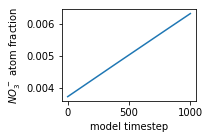

In [47]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no3-atomfraction.pdf")

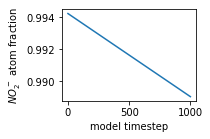

In [48]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no2-atomfraction.pdf")

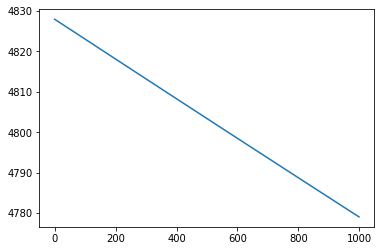

In [49]:
plt.plot(output['[NO2-]_nM'])

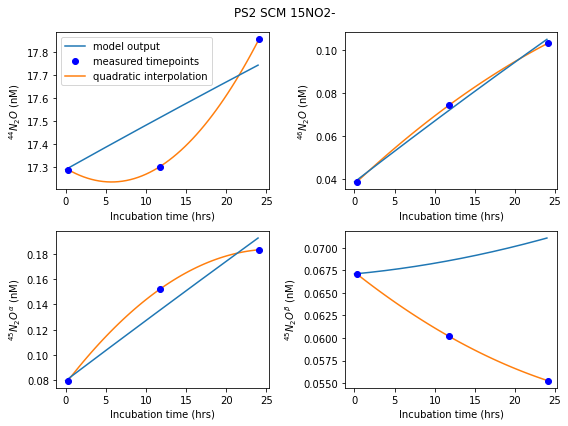

In [50]:
sc.plot_outputs(trainingdata = PS2SCM15NO2, modeloutput=output, 
             filename="Figures/PS2SCM15NO2.pdf")